In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
model_size = 'large_models'
#model_size = 'small_models'
root_dir = f'/home/rob/Documents/3_projects/bench/_results/{model_size}'
output_dir_base_path = f'/home/rob/Documents/3_projects/bench/analysis/graphs/'
os.makedirs(output_dir_base_path, exist_ok=True)

current_dir = os.getcwd()
dataset_name = "kvasir"
#dataset_name = "NucleiSeg"
#dataset_name = "URDE"
#dataset_name = "isaid"
#dataset_name = "coco"

folds = [f'fold_{i}' for i in range(5)]

perf_metric = 'IoU_score'
perf_metric_name = 'IoU Score'

model_names = ["UNet_vanilla", "UNet_e2cnn", "C8", "D4"]

In [3]:
def construct_path_from_parent(root_dir, subdir_list):
    # Construct the path using os.path.join
    return os.path.join(root_dir, *subdir_list)

In [4]:
def build_path(dataset_name: str, 
               model_name: str, 
               fold_nb: str, 
               root_dir: str = '/home/rob/Documents/3_projects/bench/_results') -> str:
    subdirs = [dataset_name, model_name, fold_nb, "summary.json"]

    summary_loc = construct_path_from_parent(root_dir, subdirs)
    if os.path.exists(summary_loc):
        print(f'summary.json loc: {summary_loc}')
    else:
        print(f'No file at the path you provided: {summary_loc}.')
    
    return summary_loc

In [5]:
# create a dict that will contain one dict per model
# each model will contain one dict per fold
# each fold will contain 2 items: time and metric
model_dicts: dict = {}

for model_name in model_names:
    # Init a key for the current model
    model_dicts[model_name] = {}
    
    # one dict with 5 keys : one per fold
    # each fold has two lists: 'time' and 'metric'
    metric_time_dict: dict = {}
    for fold in folds:
        metric_time_dict[fold] = {}
        summary_loc = build_path(dataset_name, model_name, fold, root_dir=root_dir)
        with open(summary_loc) as file:
            data = json.load(file)
            
        # extract perf & time from source
        data = data.get('test', {})
        perf_list = data[perf_metric]
        time_list = data['time']
        
        metric_time_dict[fold]['perf'] = perf_list
        metric_time_dict[fold]['time'] = time_list
    
    model_dicts[model_name] = metric_time_dict

summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_vanilla/fold_0/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_vanilla/fold_1/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_vanilla/fold_2/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_vanilla/fold_3/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_vanilla/fold_4/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_e2cnn/fold_0/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_e2cnn/fold_1/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_models/kvasir/UNet_e2cnn/fold_2/summary.json
summary.json loc: /home/rob/Documents/3_projects/bench/_results/large_

In [6]:
#model_dicts

In [7]:
average_per_model: dict = {}


In [8]:
output_path = output_dir_base_path
os.makedirs(output_path, exist_ok=True)

In [9]:
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'd'] 

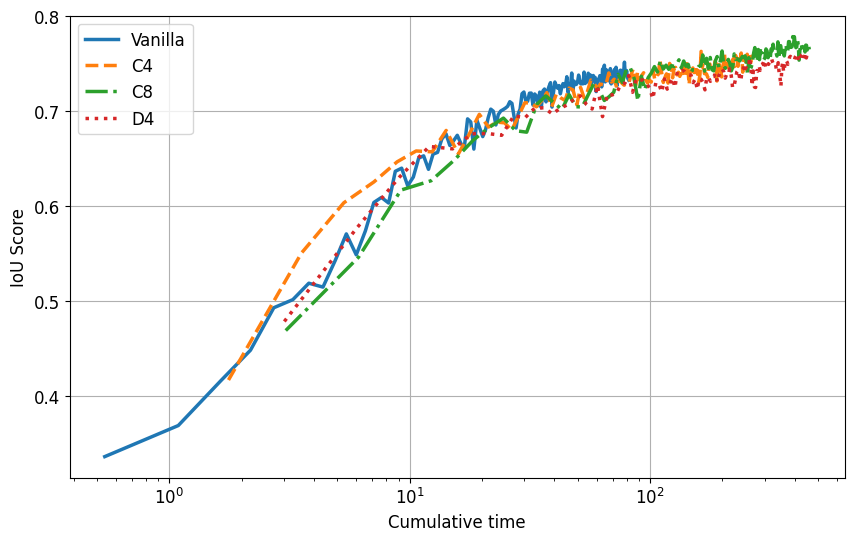

In [10]:
averages_dict: dict = {}
selected_font_size = 12

for model_name in model_dicts.keys():
    all_perf_lists = [model_dicts[model_name][fold]['perf'] for fold in folds]
    all_time_lists = [model_dicts[model_name][fold]['time'] for fold in folds]
    
    perf_array = np.array(all_perf_lists)
    time_array = np.array(all_time_lists)
    
    avg_perf = np.mean(perf_array, axis=0) 
    avg_time = np.mean(time_array, axis=0) 
    
    cumulative_time = np.cumsum(avg_time)
    
    averages_dict[model_name] = {'avg_perf': avg_perf, 'cumulative_time': cumulative_time}

plt.figure(figsize=(10, 6))

for i, model_name in enumerate(model_names):
    avg_perf_values = averages_dict[model_name]['avg_perf']
    cumulative_time_values = averages_dict[model_name]['cumulative_time']
    
    linestyle = linestyles[i % len(linestyles)]  
    marker = markers[i % len(markers)] 
    if model_name == 'UNet_e2cnn':
        model_name = 'C4'
    elif model_name == 'UNet_vanilla':
        model_name = 'Vanilla'
    plt.plot(cumulative_time_values, avg_perf_values, label=model_name, 
             linestyle=linestyle, linewidth=2.5)

plt.xlabel('Cumulative time', fontsize=selected_font_size)
plt.ylabel(perf_metric_name, fontsize=selected_font_size)
plt.xscale('log')
plt.xticks(fontsize=selected_font_size)
plt.yticks(fontsize=selected_font_size)
plt.legend(loc="best", fontsize=selected_font_size)
plt.grid(True)
output_pdf = os.path.join(output_path, f'{dataset_name}_{model_size}_plot.pdf')
plt.savefig(output_pdf, format='pdf')

plt.show()